In [1]:
!pip install "modin[ray]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import modin.pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import ray

In [3]:
ray.init()

2022-08-12 21:30:22,855	INFO services.py:1476 -- View the Ray dashboard at http://127.0.0.1:8265


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.7.13', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', address_info={'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-08-12_21-30-19_953223_5431/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-08-12_21-30-19_953223_5431/sockets/raylet', 'webui_url': '127.0.0.1:8265', 'session_dir': '/tmp/ray/session_2022-08-12_21-30-19_953223_5431', 'metrics_export_port': 45520, 'gcs_address': '172.28.0.2:45672', 'address': '172.28.0.2:45672', 'node_id': '591090a1535fdcf8a76b1b6aa7c6e6f38d55574084fd6335f75f2bcc'})

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_recall_curve, classification_report

In [5]:
data = pd.read_csv('titanic.csv')
data.head(10)

,PassengerId,Name,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,"Braund, Mr. Owen Harris",3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,"Heikkinen, Miss. Laina",3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,female,35.0,1,0,113803,53.1000,C123,S,1
4,5,"Allen, Mr. William Henry",3,male,35.0,0,0,373450,8.0500,NaN,S,0
5,6,"Moran, Mr. James",3,male,NaN,0,0,330877,8.4583,NaN,Q,0
6,7,"McCarthy, Mr. Timothy J",1,male,54.0,0,0,17463,51.8625,E46,S,0
7,8,"Palsson, Master. Gosta Leonard",3,male,2.0,3,1,349909,21.0750,NaN,S,0
8,9,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",3,female,27.0,0,2,347742,11.1333,NaN,S,1
9,10,"Nasser, Mrs. Nicholas (Adele Achem)",2,female,14.0,1,0,237736,30.0708,NaN,C,1


In [6]:
data.shape

(891, 12)

In [7]:
data.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  -----------  --------------  -----  
 0   PassengerId  891 non-null    int64
 1   Name         891 non-null    object
 2   Pclass       891 non-null    int64
 3   Sex          891 non-null    object
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64
 6   Parch        891 non-null    int64
 7   Ticket       891 non-null    object
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object
 10  Embarked     889 non-null    object
 11  Survived     891 non-null    int64
dtypes: int64(5), object(5), float64(2)
memory usage: 83.7 KB


In [8]:
data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208,0.383838
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429,0.486592
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


In [9]:
data.isna().sum()
# drop Cabin
# fill age with mean

PassengerId      0
Name             0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Survived         0
dtype: int64

In [10]:
data['Age'].fillna(30, inplace=True)

In [11]:
data.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket',	'Cabin'], axis=1, inplace=True)

In [12]:
numeric_features = ['Age', 'Fare']
# numerical_cols = [cname for cname in X_train_full.columns if 
                # X_train_full[cname].dtype in ['int64', 'float64']]
categorical_features = ['Pclass', 'Sex', 'Embarked']
# categorical_cols = [cname for cname in X_train_full.columns if
#                     X_train_full[cname].nunique() < 10 and 
#                     X_train_full[cname].dtype == "object"]

# my_cols = categorical_cols + numerical_cols

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    # ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
],
                      #  remainder='passthrough',
                      #  verbose_feature_names_out=False
                       )

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs'))
])

In [13]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [14]:
X

,Pclass,Sex,Age,Fare,Embarked
0,3,male,22.0,7.2500,S
1,1,female,38.0,71.2833,C
2,3,female,26.0,7.9250,S
3,1,female,35.0,53.1000,S
4,3,male,35.0,8.0500,S
...,...,...,...,...,...
886,2,male,27.0,13.0000,S
887,1,female,19.0,30.0000,S
888,3,female,30.0,23.4500,S
889,1,male,26.0,30.0000,C


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=4/5,
                                                    random_state=42)

In [16]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown

In [17]:
clf.score(X_test, y_test)

0.7932960893854749

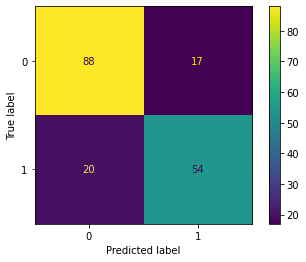

In [18]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

---

In [19]:
X_test.head()

,Pclass,Sex,Age,Fare,Embarked
709,3,male,30.0,15.2458,C
439,2,male,31.0,10.5000,S
840,3,male,20.0,7.9250,S
720,2,female,6.0,33.0000,S
39,3,female,14.0,11.2417,C


In [20]:
new_data = {
    'Pclass': [3],
    'Sex': ['male'],
    'Age': [30],
    'Fare': [15.2458],
    'Embarked': ['C']
}

new = pd.DataFrame(new_data)
new

,Pclass,Sex,Age,Fare,Embarked
0,3,male,30,15.2458,C


In [21]:
clf.predict(new)

array([0])

---

In [22]:
params = {
    'classifier__C': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001]
}
est = clf
search = GridSearchCV(est, params)

In [23]:
search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleIm

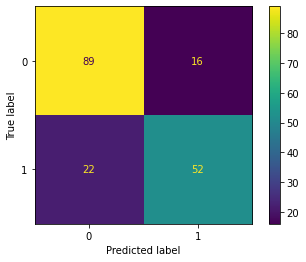

In [24]:
ConfusionMatrixDisplay.from_estimator(search, X_test, y_test)

---

In [25]:
# !pip install tune-sklearn ray[tune]

In [26]:
# from tune_sklearn import TuneGridSearchCV

In [27]:
# params = {
#     'classifier__C': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001]
# }
# est = clf
# search = TuneGridSearchCV(est, params)

In [28]:
# search.fit(X_train, y_train)

---

In [29]:
# from ray.util.joblib import register_ray
# register_ray()

In [30]:
# t1 = time.time()

# with joblib.parallel_backend('ray'):
#   search.score(X_test, y_test)

# t2 = time.time()

---

In [31]:
# from dask.distributed import Client
# client = Client()

In [32]:
# t1 = time.time()

# with joblib.parallel_backend('dask'):
#   search.score(X_test, y_test)

# t2 = time.time()
# print(t2-t1)